In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Read in dataset
df = pd.read_csv('data/reduced_qi_filled.csv')

pd.set_option('display.max_rows', 100)

# Assignment: 
Assuming that each field other than the user-id and the course name is a quasi-identifier, determine the level of k-anonymity in the file. Then, make the file 5-anonymous using only record suppression; how many records need to be deleted to do this? Try making the file 5-anonymous using only column suppression; how many columns need to be deleted to do this, and which ones are they? Finally, try to produce a 5-anonymous data set using generalization. Finally, see if you can use some combination of these mechanisms to produce a 5-anonymous data set.

# References

Dr. Latanya Sweeney's "Achieving _k_-anonymity privacy protection using generalization and suppression" (2002)
https://dataprivacylab.org/dataprivacy/projects/kanonymity/kanonymity2.pdf

# Step 0: Explore the data

In [27]:
print('Number of attributes (columns):',len(df.columns))
print('Number of records (rows):',len(df))

Number of attributes (columns): 15
Number of records (rows): 199999


In [3]:
#df.head()

# Step 1: Remove identifiers (user_id and course_id)
This leaves only quasi-identifiers.

In [4]:
df_quasi = df.drop(columns=['user_id','course_id'])

In [5]:
#df_quasi.head()

# Step 2: Determine current k-level of anonymity

In [6]:
# Sanity check for k-anonymity
print('Number of unique rows:',len(df_quasi.drop_duplicates()))

Number of unique rows: 132343


In [7]:
# For each unique row, get counts (the count of each row tells us how k-anonymous each row is)
# and move to front of df for debugging
df_counts = df_quasi.groupby(list(df_quasi.columns), dropna=False).size().to_frame('counts').reset_index()
cols = list(df_counts.columns)
df_counts = df_counts[[cols[-1]] + cols[:-1]]

print('Number of unique rows:',len(df_counts))
print('Number of all rows:',df_counts['counts'].sum())

Number of unique rows: 132343
Number of all rows: 199999


In [8]:
#df_counts.head()

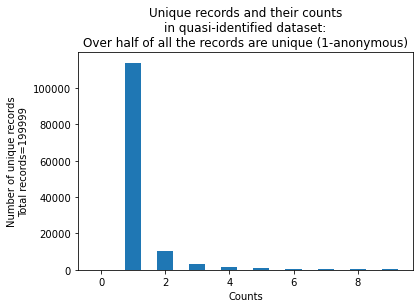

In [9]:
# Plot unique records and their counts
plt.hist(df_counts[['counts']],range=(0,10),bins=10,rwidth=0.5,align='left')
plt.title('Unique records and their counts\nin quasi-identified dataset:\nOver half of all the records are unique (1-anonymous)')
plt.xlabel('Counts')
plt.ylabel(f'Number of unique records\nTotal records={df_counts.counts.sum()}')
plt.show()

In [10]:
# Get more details
freq = df_counts[['counts']].value_counts().sort_index()
freq_dict = dict(zip(freq.index,freq.values))
for i in range(1,10):
    print(freq_dict[(i,)],'record(s) are',i,'anonymous')

113906 record(s) are 1 anonymous
10397 record(s) are 2 anonymous
3238 record(s) are 3 anonymous
1468 record(s) are 4 anonymous
845 record(s) are 5 anonymous
519 record(s) are 6 anonymous
380 record(s) are 7 anonymous
267 record(s) are 8 anonymous
180 record(s) are 9 anonymous


It appears that the dataset is currently 1-anonymous (so not anonomys at all), since most records have a count of 1--meaning that they are unique.

In [11]:
# I wrote this function based on Theorem 1 of Dr. Sweeney's paper (linked at top)
def returnMinKAnon(df):
    min_k = 100 # start at large value
    for c in df.columns:
        counts = df[c].value_counts()
        if counts[counts.idxmin()]<min_k:
            min_k = counts[counts.idxmin()]
            #print(counts.idxmin(),counts[counts.idxmin()]) # for debugging
    return min_k

In [12]:
# Sanity check
print('Should be 1:',returnMinKAnon(df_quasi))

Should be 1: 1


# Step 3: Make dataset 5-anonymous only with record suppression

First, I try to do this logically. I need to remove records that are 1-, 2-, 3-, and 4-anonymous. From before, I calculated these counts. I can find the sum and then approach it another way to sanity check. For this, I used Sweeney Figure 1 as a model.

In [13]:
df_1 = df_counts[df_counts.counts>4] # k>=5 anonymous
df_2 = df_counts[df_counts.counts<=4] # k<5 anonymous

print(df_1['counts'].sum(),'records are k>=5 anonymous')
print(df_2['counts'].sum(),'records are k<4 anonymous')
print('All records:',df_1['counts'].sum()+df_2['counts'].sum(),len(df_quasi)) # sanity check

print('Percent of records to suppress:',round(df_2['counts'].sum()/len(df_quasi)*100),'%')

49713 records are k>=5 anonymous
150286 records are k<4 anonymous
All records: 199999 199999
Percent of records to suppress: 75 %


In [14]:
df_row_suppressed = pd.merge(df_1.drop(columns=['counts']),df_quasi)
print('Size of row suppressed dataset',len(df_row_suppressed))
#df_row_suppressed.head()

Size of row suppressed dataset 49713


In [15]:
# Sanity check
print('Should be 5:',returnMinKAnon(df_row_suppressed))

Should be 5: 5


# Step 4: Make dataset 5-anonymous only with column suppression

According to Dr. Sweeney (Theorem 1 and Example 2), a table is k-anonymous if each value in each attribute appears at least k times. So, I think I can design my column suppression strategy by looking at the value_counts within each attribute.

In [16]:
# Iterate over each column, check the counts of each attribute, and
# keep track of columns where all attributes appear >5 times
cols_to_keep = []
for c in df_quasi.columns:
    counts = df_quasi[c].value_counts()
    print('Quasi identifier:',c)
    print('Most common',counts.idxmax(),counts[counts.idxmax()])
    print('Least common',counts.idxmin(),counts[counts.idxmin()],'\n')
    if counts[counts.idxmin()] > 4:
        cols_to_keep.append(c)

Quasi identifier: cc_by_ip
Most common US 59604
Least common AI 1 

Quasi identifier: city
Most common London 1894
Least common Rosengarten 1 

Quasi identifier: postalCode
Most common K2H 582
Least common 72520 1 

Quasi identifier: LoE
Most common b 59422
Least common none 535 

Quasi identifier: YoB
Most common 1990.0 8664
Least common 1910.0 1 

Quasi identifier: gender
Most common m 102399
Least common o 978 

Quasi identifier: nforum_posts
Most common 0 192059
Least common 95 1 

Quasi identifier: nforum_votes
Most common 0 197690
Least common 74 1 

Quasi identifier: nforum_endorsed
Most common 0 199904
Least common 5 1 

Quasi identifier: nforum_threads
Most common 0 195576
Least common 71 1 

Quasi identifier: nforum_comments
Most common 0 194537
Least common 220 1 

Quasi identifier: nforum_pinned
Most common 0 199987
Least common 2 1 

Quasi identifier: nforum_events
Most common 0 184430
Least common 1168 1 



In [17]:
# The only columns we can keep
print(cols_to_keep)

['LoE', 'gender']


In [18]:
df_col_suppressed = df_quasi[cols_to_keep]
print('Size of col suppressed dataset',len(df_col_suppressed))
print('Num of columns originally',len(df_quasi.columns))
print('Num of columns now',len(df_col_suppressed.columns))
#df_col_suppressed.head()

Size of col suppressed dataset 199999
Num of columns originally 13
Num of columns now 2


In [19]:
# Sanity check
print('Should be >5:',returnMinKAnon(df_col_suppressed)) # really is higher

Should be >5: 100


## Step 5: Make dataset 5-anonymous only with generalization

In [28]:
# Look in detail at each attribute
cols = ['nforum_posts', 'nforum_votes', 'nforum_endorsed', 'nforum_threads',
       'nforum_comments', 'nforum_pinned', 'nforum_events','YoB']
verbose = False
if verbose:
    for c in cols:
        counts = df_quasi[c].value_counts().sort_index()
        print('Quasi identifier:',c)
        for k,v in counts.items():
            print(k,v)
        print()

From the numeric values of each attribute above, I think I can generalize the values above by roughly finding at which point do the value counts dip below 5. Before this point, I can bucket all smaller values into one larger, more general bucket. I could do this algorithmically, but in the interest of time I will do this a bit more observationally.

From what I see above, I should make the following cutoffs:
- nforum_posts >42
- nforum_votes >23
- nforum_endorsed >3
- nforum_threads >24
- nforum_comments >41
- nforum_pinned >1
- nforum_events >122
- YoB <1923

In [29]:
# Look in detail at each categorical attribute
cols2 = ['postalCode','cc_by_ip', 'city']
verbose = False
if verbose:
    for c in cols2:
        counts = df_quasi[c].value_counts().sort_index()
        print('Quasi identifier:',c)
        for k,v in counts.items():
            print(k,v)
        print()

To generalize these others I would need a more sophisticated approach (for instance, mapping country codes to regions or cities to countries). I'm less sure about how I could generalize zip codes since these are not US-only zip codes. For now, I will generalize these columns by mapping all of them to a single value, '*'.

In [22]:
# Use our above findings to add some generalization
df_gen = df_quasi.copy()
df_gen.loc[df_gen.nforum_posts>42, 'nforum_posts'] = '>42'
df_gen.loc[df_gen.nforum_votes>23, 'nforum_votes'] = '>23'
df_gen.loc[df_gen.nforum_endorsed>3, 'nforum_endorsed'] = '>3'
df_gen.loc[df_gen.nforum_threads>24, 'nforum_threads'] = '>24'
df_gen.loc[df_gen.nforum_comments>41, 'nforum_comments'] = '>41'
df_gen.loc[df_gen.nforum_pinned>1, 'nforum_pinned'] = '>1'
df_gen.loc[df_gen.nforum_events>122, 'nforum_events'] = '>122'
df_gen.loc[df_gen.YoB<1923, 'YoB'] = '<1923'
df_gen[['city','postalCode']]='*','*'

df_mix = df_gen.copy() # used later

df_gen[['cc_by_ip']]='*'

#df_gen.head()

In [23]:
# Sanity check
print('Should be 5:',returnMinKAnon(df_gen))

Should be 5: 5


## Step 6: Make dataset 5-anonymous using mixed strategy

I'll start with using my generalization cutoffs from before. Then I use column suppression to suppress 'postalCode' and 'city'. Lastly, I use record suppression to 5-anonymize 'cc_by_ip'.

In [30]:
# Bring in 
df_mix_counts = df_mix.groupby(list(df_mix.columns), dropna=False).size().to_frame('counts').reset_index()
df_mix_keep = df_mix_counts[df_mix_counts.counts>4] # k>=5 anonymous
df_mix_final = pd.merge(df_mix_keep.drop(columns=['counts']),df_mix)
#df_mix_final.head()

In [25]:
print('Size of mixed approach dataset',len(df_mix_final))
print('Num of columns originally',len(df_quasi.columns))
print('Num of columns now',len(df_mix_final.columns))

Size of mixed approach dataset 146246
Num of columns originally 13
Num of columns now 13


In [26]:
# Sanity check
print('Should be 5:',returnMinKAnon(df_mix_final))

Should be 5: 5
